In [ ]:
import math
import numpy as np
import scipy.interpolate as ip

# Initial-final mass relation (from Lawlor and MacDonald 200)
minit = [0.80, 0.85, 0.90, 0.95, 1.000, 1.200, 1.500, 2.000, 2.500, 3.000, 4.000, 5.000, 6.500, 8.000, 10.0]
mfin  = [0.54, 0.54, 0.54, 0.54, 0.541, 0.557, 0.563, 0.595, 0.632, 0.678, 0.778, 0.874, 0.973, 1.080, 1.11]
fmfin = ip.interp1d(minit, mfin) #interpolating to form a function to find final mass

# Yields for Type II SNe, from Woosley and Weaver 1995
#Yields are in terms of absolute Mass
mww = [11.0, 12.0, 13.0, 15.0, 18.0, 19.0, 20.0, 22.0, 25.0, 30.0, 35.0, 40.0]
m16O = [1.36e-01, 2.10e-01, 2.72e-01, 6.80e-01, 1.13, 1.43, 1.94, 2.38, 3.25,3.65, 3.07, 2.36]
# mFe  = [0.0804, 0.0554, 0.1458, 0.1297, 0.0828, 0.1177, 0.1063, 0.2247, 0.1509,
#         \0.318, 0.0918, 0.051]
mFe=[1.11e-02,1.22e-02,1.28e-02,1.47e-02,1.71e-02,1.77e-02,1.83e-02,1.97e-02,\
     2.19e-02,2.50e-02,2.77e-02,2.83e-02]
f16O = ip.interp1d(mww,m16O)
fFe  = ip.interp1d(mww,mFe)

# IMF slope
# alpha = -2.35

def calcsfr(mg):
# Simple Schmidt-Kennicutt law, from Kennicutt (1998)
# Here, mg is the gas surface density (in Msun pc^-2)
    # logMg = math.log10(mg)
    # logSFR = logMg*1.4 - 3.5
    SFR = 1e-10*2.5*mg**1.4    
    return SFR

def mrem(m):

# Calculate the remnant mass for a star of initial mass m

#  Iben & Tutukov 1984 (Pagel 1997, p. 239):
   if (m < 9.5):
      mm = 0.11*m + 0.45
   else:
      mm = 1.5
   return mm

def fq16O(m):
# Mass fraction of 16O returned by a star of mass m
    if ((m > min(mww)) and (m < max(mww))):
        return f16O(m)/m
    else:
        return 0.

def fqFe(m):
# Mass fraction of Fe returned by a star of mass m
    if ((m > min(mww)) and (m < max(mww))):
        return fFe(m)/m
    else:
        return 0.

# def IMF(m):
# # Evaluate the Salpeter (1955) IMF for a star of mass m
#     mmin = 0.15
#     mmax = 100.
#     return m**alpha * -(alpha+2) / (mmin**(alpha+2) - mmax**(alpha+2))
def IMF(m):
  # alpha = -2.35
  mmin = 0.15
  mmax = 100
  if m<0.08:
    alpha = -0.3
  elif m>0.08 and m<0.5:
    alpha=-1.3
  elif m>0.5:
    alpha=-2.3
  return m**alpha * -(alpha+2) / (mmin**(alpha+2) - mmax**(alpha+2))
    



def mej(ti, at, aSFR):
# Calculate the ejected mass, from stellar evolution, at time ti.
# at and aSFR are arrays containing the time and star formation rate.
# Stellar masses and lifetimes are read from the file t_m.txt

    logt, m = np.loadtxt('/content/drive/MyDrive/GCE/t_m.txt',usecols=(0,1), unpack=True)
    t = 10**logt
    fm = ip.interp1d(t, m)
    ft = ip.interp1d(np.flipud(m), np.flipud(t))

    if (ti < min(t)):      # No stars have evolved off MS yet
        ee = 0.
    elif (len(at) < 2):
        ee = 0.
    else:
        fSFR = ip.interp1d(at, aSFR)     # Interpolate in (t, SFR) arrays    
        mt = fm(ti)                      # Lower limit of the integral
        mU = max(m)                      # Upper limit
        mm = mt            
        ee = 0.
        while (mm < mU):
            dm = mm / 25.
            tSFR = max(ti - ft(mm),0)    # Calculate SFR when star of mass
	                                     # m was born
            if (tSFR > max(at)): tSFR = max(at)
            de = (mm - mrem(mm)) * fSFR(tSFR) * IMF(mm) * dm  # ejected mass
            ee = ee + de
            mm = mm + dm

    return ee


def mejZ_SNIa(ti, at, aSFR, mZ):
# Calculate the amount of metals returned by Type Ia SNe
# mZ is the mass of the element produced by one SN explosion

    mSNIamax = 8.0   # Maximum mass of stars that become Type Ia SNe
    fSNIa    = 0.02  # Fraction of those stars that actually become Type Ia SNe
    delay = 1e9      # Time delay, after endpoint of normal stellar evolution

    logt, m = np.loadtxt('/content/drive/MyDrive/GCE/t_m.txt',usecols=(0,1), unpack=True)
    t = 10**logt + 4*delay     # Remember to add the delay
    fm = ip.interp1d(t, m)
    ft = ip.interp1d(np.flipud(m), np.flipud(t))
    w = np.where(m < mSNIamax)

    if (ti < min(t[w])):
        ee = 0.
    elif (len(at) < 2):
        ee = 0.
    else:
        fSFR = ip.interp1d(at, aSFR)
        mt = fm(ti)
        mm = mt
        ee = 0.
        while (mm < mSNIamax):
            dm = mm / 25.
            tSFR = max(ti - ft(mm),0)
            if (tSFR > max(at)): tSFR = max(at)
            de = fSNIa * mZ * fSFR(tSFR) * IMF(mm) * dm
            ee = ee + de
            mm = mm + dm

    return ee


def mejZ(ti, at, aSFR, aZ, fqZ):
# Calculate the amount of metals returned by Type II SNe
# aZ should contain the metallicity of the gas at times at
# fqZ(m) is a function that should return the mass fraction of element Z
# returned by a star with initial mass m

# The rest is largely equivalent to the function mej() above

    logt, m = np.loadtxt('/content/drive/MyDrive/GCE/t_m.txt',usecols=(0,1), unpack=True)
    t = 10**logt
    fm = ip.interp1d(t, m)
    ft = ip.interp1d(np.flipud(m), np.flipud(t))

    if (ti < min(t)):
        ee = 0.
    elif (len(at) < 2):
        ee = 0.
    else:
        fSFR = ip.interp1d(at, aSFR)
        fZ = ip.interp1d(at, aZ)
        mt = fm(ti)
        mU = max(m)
        mm = mt
        ee = 0.
        while (mm < mU):
            dm = mm / 50.
            tSFR = max(ti - ft(mm),0)
            if (tSFR > max(at)): tSFR = max(at)
            de = ((mm - mrem(mm))*fZ(tSFR) + mm*fqZ(mm)) * fSFR(tSFR) * IMF(mm) * dm
            ee = ee + de
            mm = mm + dm

    return ee

Tarr=[]
def gce_model(tmax=1.0e10, Mg0=10., Ms0=0.):
# Calculate the actual chemical evolution model.
# Mg0 is the initial gas mass (surface density; Msun pc^-2) and
# Ms0 is the initial stellar mass (surface density)

    t = 0.          
    Mg = Mg0       # Gas mass
    Ms = Ms0       # Stellar mass
    M16O = 0.      # Mass in 16O in gas phase
    MFe  =  0       # Mass in Fe in gas phase


# Arrays to store the enrichment history and related variables
    at, aMg, aMs, aSFR, aZ16O, aZFe = [], [], [], [], [], []

    while (t < tmax):

        dt = 1e6 + t/1e2    # Time steps: minimum 1e6 yr>>1% of age

        SFR = calcsfr(Mg)
        et  = mej(t, at, aSFR)

        e16O = mejZ(t, at, aSFR, aZ16O, fq16O) # O from Type II SNe
        Z16O = M16O/Mg

        eFeI = mejZ_SNIa(t, at, aSFR, 0.61)    # Fe from Type Ia SNe
        eFeII = mejZ(t, at, aSFR, aZFe, fqFe)  # Fe from Type II SNe
        eFe = eFeI + eFeII
        ZFe = MFe/Mg


        # racc = 0   # No accretion

        Z16Oej = Z16O     # Assume that ejected gas has same composition
                          # as current gas composition
        ZFeej = ZFe       
        # rwind = 0  # No Winds
#numerically integrating using Euler Method
# Update variables 
        dMg = (et - SFR) * dt
        dMs = (SFR - et) * dt
        dM16O = (e16O - Z16O*SFR ) * dt
        dMFe  = (eFe  -  ZFe*SFR) * dt
        Mg = Mg + dMg
        Ms = Ms + dMs
        M16O = M16O + dM16O
        MFe  = MFe  + dMFe 

        at.append(t)
        aSFR.append(SFR)
        aMg.append(Mg)
        aMs.append(Ms)
        aZ16O.append(M16O/Mg)
        aZFe.append(MFe/Mg)

        table=[t, Mg, Ms, SFR, et, e16O, Z16O, eFeI, eFeII, ZFe]
        Tarr.append(table)       
        t = t + dt
    return Tarr,aZFe,aZ16O,aMg,aSFR,at,aMs

In [ ]:
#run the function
import matplotlib.pyplot as plt

A,aZFe,aZ16O,aMg,aSFR,at,aMs,aZ24mg=gce_model()
A=np.array(A)

In [ ]:
aSFR

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


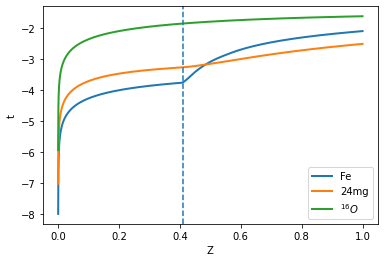

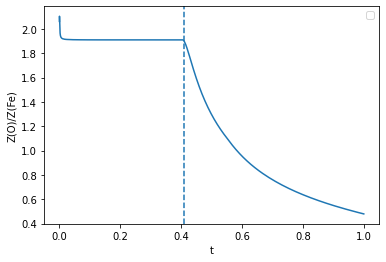

In [ ]:
#Plots 
plt.plot(at/np.max(at),np.log10(np.array(np.array(aZFe))),lw=2,label='Fe')
plt.plot(at/np.max(at),np.log10(np.array(np.array(aZ24mg))),lw=2,label='24mg')
plt.plot(at/np.max(at),np.log10(np.array(aZ16O)),lw=2,label='$ ^{16} O$')
plt.xlabel('Z')
plt.ylabel('t')
plt.axvline(x=0.41,linestyle='--')
plt.legend()
plt.figure()
plt.plot(at/np.max(at),np.log10(np.array(aZ16O)/np.array(aZFe)))

plt.ylabel('Z(O)/Z(Fe)')
plt.xlabel('t')
#plt.xlim(0.01,1.0)
plt.axvline(x=0.41,linestyle='--')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


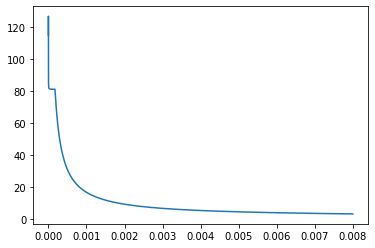

In [ ]:
plt.figure()
plt.plot(aZFe,(np.array(aZ16O)/np.array(aZFe)))

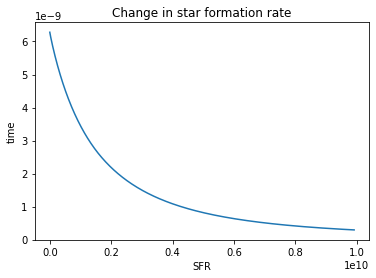

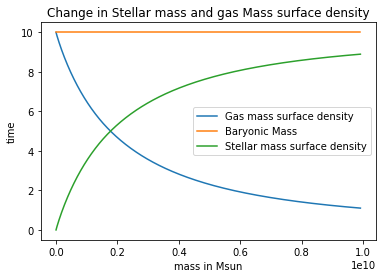

In [ ]:
plt.plot(at,aSFR)

plt.xlabel('SFR')
plt.ylabel('time')

plt.title('Change in star formation rate')
plt.figure()
plt.plot(at,aMg,label='Gas mass surface density')
plt.title('Change in Stellar mass and gas Mass surface density')
plt.plot(at,np.array(aMg)+np.array(aMs),label='Baryonic Mass')
plt.plot(at,aMs,label='Stellar mass surface density')
plt.xlabel('mass in Msun')
plt.ylabel('time')
plt.legend()